In [1]:
# SEP Tutorial with Astropy on JWST NIRCAM Images of NGC 3324

import sep
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

In [2]:
# Load JWST image
filename = "min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
hdulist = fits.open(filename)
raw_data = hdulist['SCI'].data.astype(np.float64)

In [3]:
# Fix NaNs by masking and replacing with median 
mask = np.isnan(raw_data)
data = np.copy(raw_data)
data[mask] = np.nanmedian(raw_data)  # Replace NaNs with median value

In [4]:
# background subtraction
# Using larger box sizes to better model background and reduce noise
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)
data_sub = data - bkg.back()

print(f"Global background RMS: {bkg.globalrms:.4f}")
print(f"Data min/max: {np.min(data):.2f}, {np.max(data):.2f}")

Global background RMS: 0.0636
Data min/max: -3.29, 5704.06


In [5]:
# Visualize background-subtracted image
plt.figure(figsize=(8,6))
plt.imshow(data_sub, origin='lower', cmap='gray', 
           vmin=-5*bkg.globalrms, vmax=10*bkg.globalrms)
plt.colorbar()
plt.title("Background-subtracted Image")
plt.savefig("figure1_background_subtracted.png")
plt.clf()

<Figure size 800x600 with 0 Axes>

In [6]:
# Increase SEP pixel buffer to handle sources 
sep.set_extract_pixstack(2000000)

In [7]:
# Extract sources with a higher detection threshold 
objects = sep.extract(data_sub, 5.0, err=bkg.globalrms)
print(f"Found {len(objects)} sources")

Found 15588 sources


In [8]:
# Save figure 2: Source locations 
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(data_sub, origin='lower', cmap='gray', 
          vmin=-5*bkg.globalrms, vmax=10*bkg.globalrms)
for obj in objects:
    e = plt.Circle((obj['x'], obj['y']), obj['a'], edgecolor='red', facecolor='none')
    ax.add_patch(e)
plt.title("Detected Sources")
plt.savefig("figure2_detected_sources.png")
plt.clf()

<Figure size 800x600 with 0 Axes>

In [9]:
# Photometry histogram 
fluxes = np.array([obj['flux'] for obj in objects])
plt.figure(figsize=(8,6))
plt.hist(fluxes, bins=30, log=True)
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.title("Histogram of Source Fluxes")
plt.savefig("figure3_flux_histogram.png")
plt.clf()

<Figure size 800x600 with 0 Axes>

In [10]:
# Flux statistics 
mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)

print(f"Mean flux: {mean_flux:.2f}")
print(f"Median flux: {median_flux:.2f}")
print(f"Standard deviation: {std_flux:.2f}")

Mean flux: 2329.96
Median flux: 30.78
Standard deviation: 40276.12


In [11]:
# Find brightest outlier 
outlier_idx = np.argmax(fluxes)
outlier = objects[outlier_idx]
outlier_sigma = (fluxes[outlier_idx] - mean_flux) / std_flux
print(f"Brightest source flux: {fluxes[outlier_idx]:.2f} at ({outlier['x']:.1f}, {outlier['y']:.1f})")
print(f"It is {outlier_sigma:.2f} sigma above the mean")

Brightest source flux: 3317093.00 at (6434.2, 5278.7)
It is 82.30 sigma above the mean


In [12]:
# Save figure 4: Mark brightest outlier
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(data_sub, origin='lower', cmap='gray', 
          vmin=-5*bkg.globalrms, vmax=10*bkg.globalrms)
ax.plot(outlier['x'], outlier['y'], 'ro', markersize=10, label='Brightest Source')
ax.legend()
plt.title("Brightest Outlier")
plt.savefig("figure4_outlier.png")
plt.clf()

<Figure size 800x600 with 0 Axes>

In [13]:
file_reference = "min_jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
with fits.open(file_reference) as hdulist:
   
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data


In [15]:
# Reference WCS and shape from clear-f090w image
ref_wcs = WCS(ref_header)
output_shape = ref_data.shape

In [16]:
fname1 = "min_jw02731-o001_t017_nircam_clear-f187n_i2d.fits"
fname2 = "min_jw02731-o001_t017_nircam_clear-f200w_i2d.fits"
fname3 = "min_jw02731-o001_t017_nircam_clear-f335m_i2d.fits"
fname4 = "min_jw02731-o001_t017_nircam_clear-f444w_i2d.fits"
fname5 = "min_jw02731-o001_t017_nircam_f444w-f470n_i2d.fits"

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

In [18]:
# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)

In [19]:
 # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

In [20]:
# Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
new_header = ref_header.copy()

In [21]:
# Save the new file
out_name = fname.replace('.fits', '_reproj.fits')
hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
hdu.writeto(out_name, overwrite=True)
print(f"Reprojected {fname} -> {out_name}")

Reprojected min_jw02731-o001_t017_nircam_f444w-f470n_i2d.fits -> min_jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits


In [22]:
# Load the reprojected FITS files
r = fits.getdata("min_jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits")
g = fits.getdata("min_jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits")
b = fits.getdata("min_jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits")

In [23]:
# Normalize and scale data
def normalize(data, stretch=0.5, Q=10):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    data = np.arcsinh(Q * data / np.percentile(data, 99)) / Q
    return np.clip(data / stretch, 0, 1)

r_scaled = normalize(r)
g_scaled = normalize(g)
b_scaled = normalize(b)

In [24]:
# Stack into RGB
rgb_image = np.dstack((r_scaled, g_scaled, b_scaled))

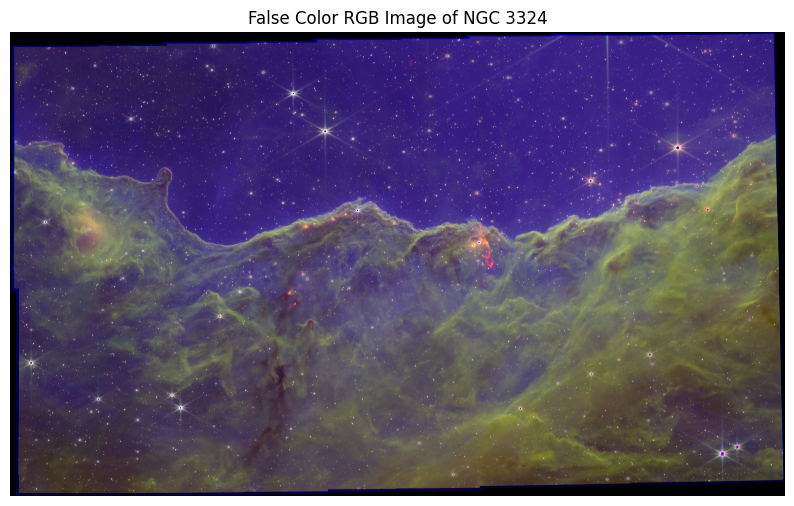

In [46]:
# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.axis('off')
plt.title("False Color RGB Image of NGC 3324")
plt.show()

In [47]:
# Save as PNG
plt.imsave("NGC3324_falsecolor.png", rgb_image, origin='lower')
print("Saved RGB image as NGC3324_falsecolor.png")

Saved RGB image as NGC3324_falsecolor.png
